In [88]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from scipy.stats import norm 
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.integrate import quad

# STATISTICAL INFERENCE FOR A DARK MATTER SEARCH
You will reproduce a direct detection experiment searching for WIMP dark matter with a dual-phase TPC (a simplified version of XENON1T). 

Targets of the excercise:

- [ ] Build a 2D statistical model for the expected signal and backgrounds 
- Given a (simulated) dataset you will compute the **exclusion limit** on the WIMP cross section using both 
    - [ ] the simple **Likelihood Ratio method**
    - [ ] and the **Profile Likelihood Ratio method** introducing nuisance parameters. 
- [ ] Estimate the **expected experimental sensitivity**
- [ ] (Optional extra) Estimate the **expected discovery potential** with 3$\sigma$ significance and test your dataset for **discovery** (and eventually set confidence interval on the WIMP cross section).
- [ ] (Optional extra) Study the sensitivity as a function of background expected **rate** and **uncertainty**
- [ ] (Optional extra) Study the sensitivity as a function of **exposure**

# 1. BUILD THE STATISTICAL MODEL

We use a 2D analysis space:
- **S1 signal** (unit: PE, photoelectrons) | The primary scintillation signal in a TPC. It is a proxy for event energy
- **Y discrimination parameter** | The "flattened" $\log_{10}$(S2/S1). A parameter for which electronic (ER) and nuclear recoils (NR) are well separated.

We fix:
- The **region of interest** (RoI) for this WIMP search as the interval **(3,70) PE in the S1 space**.
- The fiducial target mass as **1000 kg**
- The data taking livetime as **2 years**
- ... thus the **exposure** is $2\,t\,y$ (mass $\times$ livetime)

Signal and background models:
- **Signal**: WIMP of 50 GeV/c$^2$ mass 
- **Backgrounds**
    - *ER background*: sum of external (e.g. gammas from detector materials, neutrinos) and intrinsic sources (e.g. Rn222, Kr85) 
    - *NR background*: sum of neutron (mainly radiogenic neutrons from materials) and neutrino sources (CE$\nu$NS mainly from solar neutrinos)
    
We need to model signal and backgrounds in the 2D space (S1, Y). Therefore we need:
- Probability density functions (**PDF**s) in S1 and Y
- **Expectation values** ($\mu$), i.e. expected number of events

## 1.1 S1 PDFs
We provide you with the expected spectra in txt files: [link to folder](url)

You need to:
- interpolate the binned spectra
- normalize to 1 (i.e. transform into PDFs) in the RoI (3,70) PE

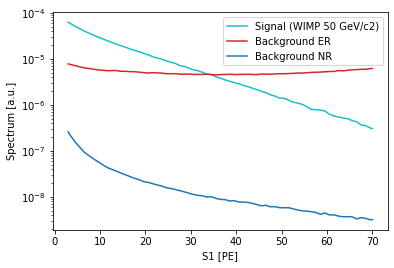

In [32]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Read input spectra for signal and backgrounds
#/////////////////////////////////////////////////////////////////////////////////////////////////

# Read signal and background S1 spectra
signal = pd.read_csv('Sig-WIMP-50-S1.txt', sep=' ')
backgroundER = pd.read_csv('Bkg-ER-S1.txt', sep=' ')
backgroundNR = pd.read_csv('Bkg-NR-S1.txt', sep=' ')

# Interpolate binned data
f_signal = interp1d(signal.S1, signal.spectrum)
f_backgroundER = interp1d(backgroundER.S1, backgroundER.spectrum)
f_backgroundNR = interp1d(backgroundNR.S1, backgroundNR.spectrum)

# Visualize spectra
fig, ax = plt.subplots(1, 1)
x = np.linspace(3,70,1000)
ax.plot(x, f_signal(x)*1e-5, 'b-', color='tab:cyan', label='Signal (WIMP 50 GeV/c2)')
ax.plot(x, f_backgroundER(x), color='tab:red', label='Background ER')
ax.plot(x, f_backgroundNR(x), color='tab:blue', label='Background NR')
plt.xlabel('S1 [PE]')
plt.ylabel('Spectrum [a.u.]')
plt.yscale('log')
plt.legend()
plt.show()

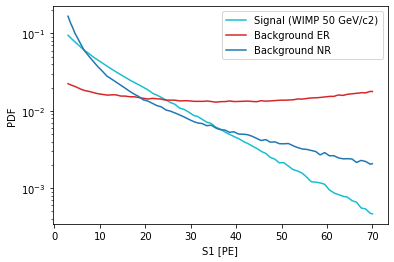

In [33]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Signal and background PDFs (S1)
#/////////////////////////////////////////////////////////////////////////////////////////////////

def normalize2pdf(func, xmin=3, xmax=70):
    '''
    Return a PDF (distribution normalized to 1)
    in the interval (xmin,xmax)
    '''
    stepsize = 0.01
    #xmin = 3
    #xmax = 70
    
    # compute the integral of original distribution
    integral = 0
    for x in np.arange(xmin+0.5*stepsize, xmax-0.5*stepsize, stepsize):
        integral += func(x)*stepsize
    #print(integral)
    
    pdf = lambda x : func(x)/integral
    return pdf

#print(quad(f_signal,3,70))
pdf_signal = normalize2pdf(f_signal)
#print(quad(pdf_signal,3,70))

#print(quad(f_backgroundER,3,70))
pdf_backgroundER = normalize2pdf(f_backgroundER)
#print(quad(pdf_backgroundER,3,70))

#print(quad(f_backgroundNR,3,70))
pdf_backgroundNR = normalize2pdf(f_backgroundNR)
#print(quad(pdf_backgroundNR,3,70))

# Visualize PDFs
fig, ax = plt.subplots(1, 1)
x = np.linspace(3,70,1000)
ax.plot(x, pdf_signal(x), 'b-', color='tab:cyan', label='Signal (WIMP 50 GeV/c2)')
ax.plot(x, pdf_backgroundER(x), color='tab:red', label='Background ER')
ax.plot(x, pdf_backgroundNR(x), color='tab:blue', label='Background NR')
plt.xlabel('S1 [PE]')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()
plt.show()

## 1.2 PDFs in discrimination space (Y)

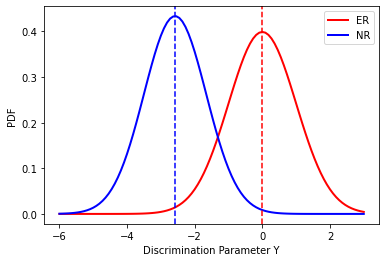

In [4]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Discrimination space (Y)
#/////////////////////////////////////////////////////////////////////////////////////////////////

# ER and NR distributions
er_discr = norm()
nr_discr = norm(loc=-2.58, scale=0.92)
# This reproduces the following separation between ER and NR populations:
# 99.5% ER rejection with 50% NR acceptance

# Visualize PDFs
fig, ax = plt.subplots()
fig.figsize = (16,8)
x = np.linspace(-6,3,100)
ax.plot(x, er_discr.pdf(x), 'r-', lw=2, label='ER')
ax.plot(x, nr_discr.pdf(x), 'b-', lw=2, label='NR')
plt.axvline(-2.58, ls='--', color='b')
plt.axvline(0, ls='--', color='r')
plt.xlabel('Discrimination Parameter Y')
plt.ylabel('PDF')
plt.legend()
plt.show()

## 1.3 Rates and expectation values

In [31]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Rates and expectation values
#/////////////////////////////////////////////////////////////////////////////////////////////////

# Region of Interest (S1 ROI)
S1min = 3   #PE
S1max = 70  #PE
RoI = S1max - S1min

# Rates 
# Expected number of events in the S1 ROI 
# per unit energy (or better S1 signal amplitude)
# per unit target mass 
# per unit time
rate_sig   = 0.04 #(/PE/t/y) # 50 GeV/c2 WIMP with cross section = 1.0e-47 cm2
rate_bkgER = 1.85 / 2  #(/PE/t/y)
rate_bkgNR = 0.03  #(/PE/t/y)

# Exposure
mass     = 1.0 #tonnes
livetime = 2.0 #years
exposure = mass * livetime

def nsig2xs(nsig, exp = exposure):
    '''
    Converts no. of signal events into cross section
    given a benchmark rate of 0.04 events/PE/t/y
    for a cross section of 1.0e-47 cm2
    
    Returns a cross section scaling factor
    with respect to the benchmark 1.0e-47 cm2
    '''
    xs = nsig/(rate_sig * exp * RoI)
    return xs

#/// Expectation values
mu_sig   = rate_sig * exposure * RoI
mu_bkgER = rate_bkgER * exposure * RoI
mu_bkgNR = rate_bkgNR * exposure * RoI

print('/// Expectation values in the S1 RoI (%.0f,%.0f) PE and %.1f ty exposure' % (S1min, S1max, exposure))
print('Signal:', mu_sig, '(50 GeV WIMP with cross section = 1.0e-47 cm2)')
print('Background ER:', mu_bkgER)
print('Background NR:', mu_bkgNR)

/// Expectation values in the S1 RoI (3,70) PE and 2.0 ty exposure
Signal: 5.36 (50 GeV WIMP with cross section = 1.0e-47 cm2)
Background ER: 123.95
Background NR: 4.02


## 1.4 Toy-Dataset random generator
Generate random datasets in the 2D space (S1,Y) based on the signal/background PDFs and expectation values

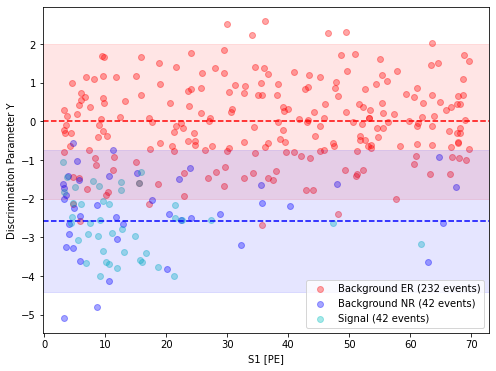

In [6]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Toy Dataset Generator (in 2D space: S1,Y)
#/////////////////////////////////////////////////////////////////////////////////////////////////
def random_sampling_pdf(x0,x1,pdf,size):
    '''
    Random sampling based on custom PDF
    x0   : x lower bound
    x1   : x upper bound
    pdf  : custom function normalized to 1
    size : number of events to generate
    '''
    sample=[]
    nLoop=0
    while len(sample)<size:
        x=np.random.uniform(low=x0,high=x1)
        prob=pdf(x)
        assert prob>=0 and prob<=1
        if np.random.uniform(low=0,high=1) <= prob:
            sample.append(x)
        nLoop+=1 
    return sample

def generate_subset(S1_pdf, Y_pdf, size):
    '''
    Returns a Pandas dataframe with random generated events
    S1_pdf : pdf_signal, pdf_backgroundER or pdf_backgroundNR
    Y_pdf  : er_discr or nr_discr
    size   : number of events
    '''
    S1s = random_sampling_pdf(3,70,S1_pdf,size)
    Ys  = Y_pdf.rvs(size=size)
    dict = {'S1': S1s, 'Y': Ys}
    df = pd.DataFrame(dict)
    return df


#/// Quick example ////////////////////////////////////////////////////////////////////////////////////////////
#/// Number of events (Poisson generation)
n_sig   = np.random.poisson(mu_sig * 10) # enhance no. of signal events (just to visualize it better) 
n_bkgER = np.random.poisson(mu_bkgER)
n_bkgNR = np.random.poisson(mu_bkgNR * 10) # enhance no. of background NR events (just to visualize it better) 

#/// Dataset generation
dataset_sig   = generate_subset(pdf_signal,nr_discr,n_sig)
dataset_bkgER = generate_subset(pdf_backgroundER,er_discr,n_bkgER)
dataset_bkgNR = generate_subset(pdf_backgroundNR,nr_discr,n_bkgNR)
dataset = pd.DataFrame()
dataset = dataset.append([dataset_sig, dataset_bkgER, dataset_bkgNR]) # toy experiment

# Plot dataset
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(dataset_bkgER.S1, dataset_bkgER.Y, color='r', alpha=0.35, label='Background ER (%d events)' % n_bkgER)
ax.scatter(dataset_bkgNR.S1, dataset_bkgNR.Y, color='b', alpha=0.35, label='Background NR (%d events)' % n_bkgNR)
ax.scatter(dataset_sig.S1, dataset_sig.Y, color='c', alpha=0.35, label='Signal (%d events)' % n_sig)
# draw Y distributions (median and 2 sigma band)
plt.axhspan(-2, 2, color='r', alpha=0.1)
plt.axhline(0, ls='--', color='r')
plt.axhspan(-2.58-2*0.92, -2.58+2*0.92, color='b', alpha=0.1)
plt.axhline(-2.58, ls='--', color='b')

plt.xlabel('S1 [PE]')
plt.ylabel('Discrimination Parameter Y')
plt.legend() 
plt.show()
#/// Quick example ////////////////////////////////////////////////////////////////////////////////////////////


def generate_toy_dataset(mu_sig, mu_bkgER=mu_bkgER, mu_bkgNR=mu_bkgNR, plot=False):
    '''
    Returns
    dataset : a dataframe of generated events (Toy experiment)
    subsets : list of dataframes for signal, background ER and NR
    '''
    n_sig   = np.random.poisson(mu_sig) 
    n_bkgER = np.random.poisson(mu_bkgER)
    n_bkgNR = np.random.poisson(mu_bkgNR)
    #print('No. generated events:', n_sig, '(signal)', n_bkgER, '(bkgER)', n_bkgNR, '(bkgNR)')

    #/// Dataset generation
    dataset_sig   = generate_subset(pdf_signal,nr_discr,n_sig)
    dataset_bkgER = generate_subset(pdf_backgroundER,er_discr,n_bkgER)
    dataset_bkgNR = generate_subset(pdf_backgroundNR,nr_discr,n_bkgNR)
    subsets = [dataset_sig, dataset_bkgER, dataset_bkgNR]
    dataset = pd.DataFrame()
    dataset = dataset.append(subsets) # toy experiment
    
    if plot:
        plot_toy_dataset(subsets, mu_sig)
    
    return dataset, subsets

def plot_toy_dataset(subsets, mu_sig=None):
    '''
    Plotting a toy dataset in 2D space (S1, Y)
    '''
    dataset_sig = subsets[0]
    dataset_bkgER = subsets[1]
    dataset_bkgNR = subsets[2]
    n_sig = len(dataset_sig)
    n_bkgER = len(dataset_bkgER)
    n_bkgNR = len(dataset_bkgNR)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot()
    ax.scatter(dataset_bkgER.S1, dataset_bkgER.Y, color='r', alpha=0.35, label='Background ER (%d)' % n_bkgER)
    ax.scatter(dataset_bkgNR.S1, dataset_bkgNR.Y, color='b', alpha=0.35, label='Background NR (%d)' % n_bkgNR)
    ax.scatter(dataset_sig.S1, dataset_sig.Y, color='c', alpha=0.75, label='Signal (%d)' % n_sig, s=100)
    # draw Y distributions (median and 2 sigma band)
    #plt.axhspan(-2, 2, color='r', alpha=0.1)
    plt.axhline(0, ls='--', color='r')
    #plt.axhspan(-2.58-2*0.92, -2.58+2*0.92, color='b', alpha=0.1)
    plt.axhline(-2.58, ls='--', color='b')
    plt.title('Signal expectation value µ_sig = %.1f (µ_ER=%.1f, µ_NR=%.1f)' % (mu_sig, mu_bkgER, mu_bkgNR))

    plt.xlabel('S1 [PE]')
    plt.ylabel('Discrimination Parameter Y')
    plt.legend(title='Generated events') 
    plt.show()

# 2. INFERENCE WITH THE LIKELIHOOD RATIO METHOD (Exclusion limit)
Given a dataset, perform the statistical inference using the Likelihood Ratio method to derive the exclusion limit on the WIMP cross section at the 90% confidence level (CL).
So find the WIMP cross section at which the signal hypothesis ($H_{\mu}$) is rejected with 90% CL, i.e. the probability to get a larger disagreement between the observed data and the signal hypothesis (observed p-value) is 1-CL = 0.1. 


The **parameter of interest** is the signal strength $\mu_{sig}$ (number of signal events), which is proportional to the WIMP *cross section* $\sigma$.

- [ ] Write the **Likelihood function** $L(\mu_{sig})$
- [ ] Fit data and find the **maximum likelihood estimator** (MLE) of $\mu_{sig}$

To compute the p-value, for $H_{\mu}$ rejection, observed with a given dataset, we use the **Likelihood Ratio test statistic** ($q_{\mu}$) and we need the expected distribution (**PDF**) of the test statistic under the signal hypothesis $f(q_{\mu}|H_\mu)$.

For searches of rare events, one needs to estimate $f(q_{\mu}|H_\mu)$ for each $\mu_{sig}$ via toy-MC: random generation of many pseudo-experiments (toy dataset) and evaluate $q_{\mu}$ on each of them. The required statistic is $>10^{3-4}$ toy-MCs. This is quite computationally expensive, therefore we provide you with already estimated $f(q_{\mu}|H_\mu)$ for $\mu_{sig}$ in the range (0,40).

- [ ] Write the **Likelihood Ratio test statistic** ($q_{\mu}$)
- [ ] Compute the value of the test statistic $q_{\mu}$ for the given dataset for different signal strengths $\mu_{sig}$,
- [ ] compute the associated **p-value** based on the test statistic PDF under the signal hypothesis $f(q_{\mu}|H_\mu)$
- [ ] Find $\mu_{sig}$ at which p-value = 0.1 (this is your limit at 90% CL)
- [ ] Convert the limit from number of events into cross section

## 2.1 Likelihood function

### 2.1.1 Likelihood curve vs $\mu_{sig}$ and the MLE $\hat{\mu}$

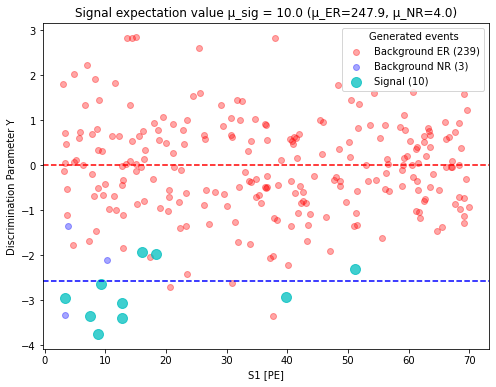

Fit convergence: True


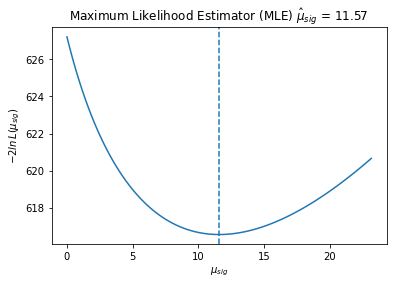

In [7]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood function definition
#/////////////////////////////////////////////////////////////////////////////////////////////////
def logLikelihood(parameter):
    '''
    -2 * Log-Likelihood function
    '''
    # expectation values
    mu_sig = parameter
    mu_tot = mu_sig + mu_bkgER + mu_bkgNR
    # data points
    x = np.array(dataset.S1)
    y = np.array(dataset.Y)
    # log-Likelihood
    LL = - mu_tot
    for i in range(0, len(dataset)):
        LL += np.log(mu_sig * pdf_signal(x[i]) * nr_discr.pdf(y[i]) + mu_bkgER * pdf_backgroundER(x[i]) * er_discr.pdf(y[i]) + mu_bkgNR * pdf_backgroundNR(x[i]) * nr_discr.pdf(y[i]))
    return -2*LL




#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood fit on an example toy-experiment dataset
#/////////////////////////////////////////////////////////////////////////////////////////////////

#/// Toy-experiment dataset
dataset, subsets = generate_toy_dataset(mu_sig = 10, plot=True)

#/// Unconstrained likelihood minimization
# Maximum likelihood estimator of mu_sig
mu_sig = 10
fit_res = minimize(logLikelihood, mu_sig, bounds=[(-100,1000)])
mle = fit_res['x'][0]
print('Fit convergence:', fit_res['success'])
#print(r'Maximum Likelihood Estimator (MLE) µ_sig-hat:', mle)
#print(fit_res)

#/// Plot log-Likelihood function vs mu_sig
mu = np.linspace(0,mle*2,100)
plt.plot(mu, logLikelihood(mu))
plt.axvline(mle, ls='--')
plt.xlabel('$\mu_{sig}$')
plt.ylabel('$-2ln\,L(\mu_{sig})$')
plt.title('Maximum Likelihood Estimator (MLE) $\hat{\mu}_{sig}$ = %.2f' % mle)
plt.show()

## 2.2 Test statistic: Likelihood ratio

In [8]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood ratio test statistic (for signal hypotesis rejection)
#/////////////////////////////////////////////////////////////////////////////////////////////////
def q_mu(mu_sig, mle):
    if mle < 0:
        q = logLikelihood(mu_sig) - logLikelihood(0) # this is in for q_tilde
    if mle <= mu_sig:
        q = logLikelihood(mu_sig) - logLikelihood(mle)
    else:
        q = 0
    return q

In [34]:
#/// Setup output file for test statistic distributions
picklefile = 'test_stat_distributions.pkl' # file to store test stat distributions

# Create empty dataframe and write to file (if needed)
#df_q = pd.DataFrame()
#df_q.to_pickle(picklefile)

### 2.2.1 Test statistic PDF under signal hypothesis: $f(q_\mu|H_\mu)$

In [10]:
from IPython.display import display
import ipywidgets as widgets

#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Test statistic distribution under a given signal hypothesis: mu_sig
#/////////////////////////////////////////////////////////////////////////////////////////////////
def qmu_Hmu_distr(mu_sig, ntoys=1000, write2pickle=True):
    '''
    Compute f(q_mu|H_mu) with toy-MC (many toy-datasets)
    Test static distribution under signal hypothesis H_mu
    For a given signal strength mu_sig tested
    
    mu_sig : test signal strength
    ntoys  : no. of toy-experiment datasets to be simulated
    
    write2pickle : save q values in a dataframe and write to pickle file
    
    Returns array of test statistic values
    '''
    print('Generating %d toy-datasets...' % ntoys)
    out = widgets.HTML()
    display(out)
    
    q_Hmu = [] # array of test statistic values for all toy-datasets
    for i in range(0,ntoys):
        # toy-dataset generation with signal (mu_sig)
        #start = time.time()
        global dataset
        dataset, subsets = generate_toy_dataset(mu_sig = mu_sig, plot=False)
        #end = time.time()
        #print('Toy generation: %.1f s' % (end-start))
        
        # maximum likelihood estimator for mu_sig
        #start = time.time()
        fit_res = minimize(logLikelihood, mu_sig, bounds=[(-10,mu_sig*20)])
        #end = time.time()
        #print('Likelihood fit: %.1f s' % (end-start))
        mle = fit_res['x'][0]
        #print(fit_res)
        
        # test statistic value for the specific toy-dataset
        q_Hmu.append(q_mu(mu_sig, mle)) 
        #print(q_mu(mu_sig, mle))
        
        # print progress information
        string = "<p>Progress: %d / %d</p>" % (i+1, ntoys)
        out.value = string
    
    if write2pickle:
        df_q = pd.read_pickle(picklefile)
        column = 'q_Hmu_%.1f' % mu_sig
        df_q[column] = [q_Hmu]
        df_q.to_pickle(picklefile)
        print('Array %s written to file %s' % (column, picklefile))
        
    return q_Hmu

### 2.2.2 Test statistic PDF under null (background-only) hypothesis: $f(q_\mu|H_0)$

In [11]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Test statistic distribution under the null hypothesis: mu_sig = 0
#/////////////////////////////////////////////////////////////////////////////////////////////////
def qmu_H0_distr(mu_sig, ntoys=1000, write2pickle=True):
    '''
    Compute f(q_mu|H_mu) with toy-MC (many toy-datasets)
    Test static distribution under null hypothesis H_0
    For a given signal strength mu_sig tested
    
    mu_sig : test signal strength
    ntoys  : no. of toy-experiment datasets to be simulated
    
    write2pickle : save q values in a dataframe and write to pickle file
    
    Returns array of test statistic values
    '''
    print('Generating %d toy-datasets...' % ntoys)
    out = widgets.HTML()
    display(out)

    q_H0 = [] # array of test statistic values for all toy-datasets
    for i in range(0,ntoys):
        # toy-dataset generation with signal (mu_sig)
        global dataset
        dataset, subsets = generate_toy_dataset(mu_sig = 0)
        # maximum likelihood estimator for mu_sig
        fit_res = minimize(logLikelihood, mu_sig, bounds=[(-20,20)])
        mle = fit_res['x'][0]
        # test statistic value for the specific toy-dataset
        q_H0.append(q_mu(mu_sig, mle))
        # print progress information
        string = "<p>Progress: %d / %d</p>" % (i+1, ntoys)
        out.value = string
        
    if write2pickle:
        df_q = pd.read_pickle(picklefile)
        column = 'q_H0_%.1f' % mu_sig
        df_q[column] = [q_H0]
        df_q.to_pickle(picklefile) 
        print('Array %s written to file %s' % (column, picklefile))
        
    return q_H0

## 2.3 p-value

In [12]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Compute p-value
#/////////////////////////////////////////////////////////////////////////////////////////////////
def get_pvalue(test_stat_distr, q):
    '''
    Returns p-value
    ---
    test_stat_distr : (array) test statistic distribution (e.g. f(qmu|Hmu) for Hmu rejection)
    q : a specific test statistic value
    '''
    pvalue = sum(1 for i in test_stat_distr if i > q) / len(test_stat_distr)
    return pvalue

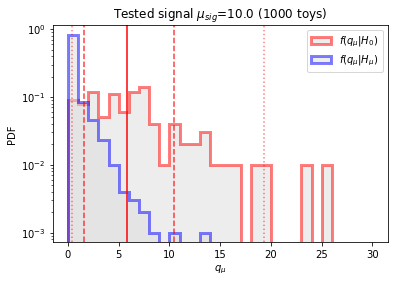

In [13]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Plot test statistic PDFs under signal (H_mu) and null (H_0) hypotheses
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Plot f(q_mu|H_mu) and f(q_mu|H0) and quantiles
percentiles = [97.72, 84.13, 50, 15.87, 2.28] # [-2sigma, -1sigma, median, +1sigma, +2sigma]

def plot_test_stat_distr_Hmu_H0(mu_sig, xmax=30, nbins=30):
    # Retrieve test statistic distributions
    df = pd.read_pickle('test_stat_distributions.pkl')
    q_Hmu = df['q_Hmu_%.1f' % mu_sig][0]
    q_H0  = df['q_H0_%.1f' % mu_sig][0]

    # Plot settings
    xmax  = 30
    nbins = 30
    pdf_qmu_H0 = plt.hist(q_H0, range=(0,xmax), bins=nbins, density=True, 
                          histtype='stepfilled', color='gainsboro', edgecolor='r', alpha = 0.5, lw=3,
                          label='$f(q_\mu|H_0)$')
    pdf_qmu_Hmu = plt.hist(q_Hmu, range=(0,xmax), bins=nbins, density=True, 
                           histtype='stepfilled', color='gainsboro', edgecolor='b', alpha=0.5, lw=3,
                           label='$f(q_\mu|H_\mu)$')
    
    # show quantiles of f(q_mu|H0)
    alphas = [0.5,0.75,1,0.75,0.5]
    linestyles = [':','--','-','--',':']
    for i, percentile in enumerate(percentiles):
        q = np.percentile(q_H0, percentile)
        plt.axvline(q, color='r', ls=linestyles[i], alpha=alphas[i])
    
    plt.yscale('log')
    plt.xlabel('$q_\mu$')
    plt.ylabel('PDF')
    plt.title('Tested signal $\mu_{sig}$=%.1f (%d toys)' % (mu_sig, len(q_Hmu)))
    plt.legend()
    plt.show()
    
plot_test_stat_distr_Hmu_H0(10)

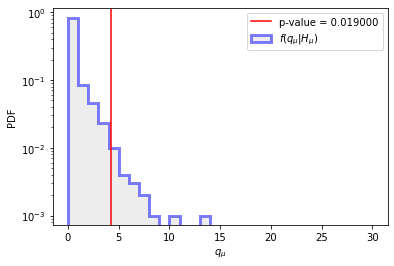

In [22]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Plot f(qmu|Hmu) 
#///(optional) show a given q value and the corresponding p-value) 
#/////////////////////////////////////////////////////////////////////////////////////////////////
def plot_test_stat_distr_Hmu(mu_sig, xmax=30, nbins=30, q=None):
    '''
    test_stat_distr : (array) test statistic distribution (e.g. f(qmu|Hmu) for Hmu rejection)
    q : a specific test statistic value
    '''
    # Retrieve f(qmu|Hmu) for mu=mu_sig
    df = pd.read_pickle('test_stat_distributions.pkl')
    q_Hmu = df['q_Hmu_%.1f' % mu_sig][0]
    
    # Plot test statistic distribution
    plt.hist(q_Hmu, range=(0,xmax), bins=nbins, density=True, 
             histtype='stepfilled', color='gainsboro', edgecolor='b', alpha = 0.5, lw=3,
             label='$f(q_\mu|H_\mu)$')
    
    # Show test statistic outcome and p=value
    if q != None:
        pvalue = get_pvalue(q_Hmu, q)
        plt.axvline(q, color='r', label='p-value = %f' % pvalue)
    
    plt.yscale('log')
    plt.xlabel('$q_\mu$')
    plt.ylabel('PDF')
    plt.legend()
    plt.show()
    
plot_test_stat_distr_Hmu(10, q=4.23)

## 2.4 Exclusion limit at 90% CL

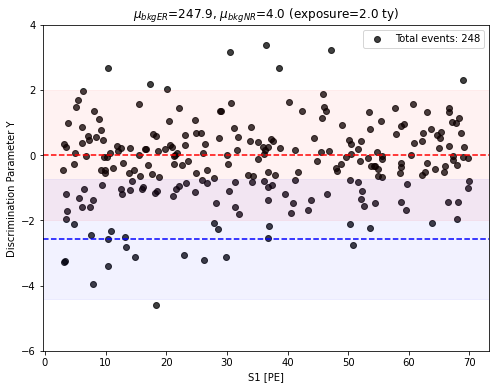

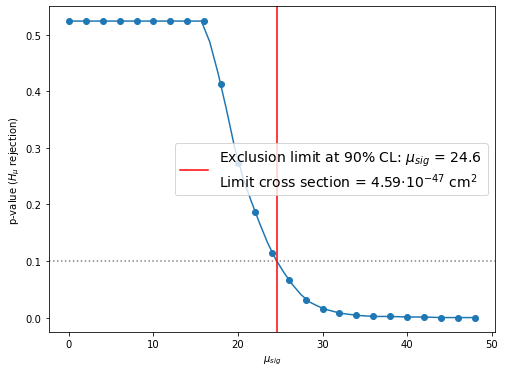

In [14]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Compute exclusion limit for a single toy-experiment
#/////////////////////////////////////////////////////////////////////////////////////////////////

#/// Generate a pseudo-experiment (i.e. a toy-dataset)
mu_sig = np.random.uniform(0,20)
#print('Toy dataset generated with %d expected signal events' % mu_sig)
dataset,_ = generate_toy_dataset(mu_sig=mu_sig)
# or use a given dataset
# dataset = <some_generated_dataset>

#/// Plot dataset in (S1,Y) space
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(dataset.S1, dataset.Y, color='k', alpha=0.75, label='Total events: %d' % len(dataset))
plt.axhspan(-2, 2, color='r', alpha=0.05)
plt.axhline(0, ls='--', color='r')
plt.axhspan(-2.58-2*0.92, -2.58+2*0.92, color='b', alpha=0.05)
plt.axhline(-2.58, ls='--', color='b')
plt.ylim(-6,4)
plt.xlabel('S1 [PE]')
plt.ylabel('Discrimination Parameter Y')
plt.legend() 
plt.title('$\mu_{bkgER}$=%.1f, $\mu_{bkgNR}$=%.1f (exposure=%.1f ty)' % (mu_bkgER, mu_bkgNR, exposure))
plt.show()

#/// Likelihood fit: find MLE for mu_sig
fit_res = minimize(logLikelihood, mu_sig, bounds=[(-100,100)])
mle = fit_res['x'][0]
#print(fit_res)

#/// Compute p-value for H_mu rejection for different signal strengths mu_sig
#--- We choice a unique benchmark f(qmu|Hmu) for anu mu_sig
#--- i.e. we are assuming the distribution is always the same for any mu_sig!
#--- Not necessarily true, especially for small values mu_sig
df = pd.read_pickle('test_stat_distributions.pkl')
q_Hmu = df['q_Hmu_%.1f' % 10][0]

mus = [] # array of tested mu_sig
pvalues = [] # array of p-values

mu_max = 50
step = 2
for mu_sig in range(0,mu_max,step):
    mus.append(mu_sig) # signal tested
    q = q_mu(mu_sig, mle) # value of test statistic q_mu
    pvalues.append(get_pvalue(q_Hmu, q)) # p-value
    #plot_test_stat_distr_Hmu(mu_sig=10, q=q) # visualize q vs f(qmu|Hmu) 
    
#/// Plot p-value vs mu_sig
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
p_func = interp1d(mus, pvalues) # Interpolate p-value curve
x = np.linspace(0,mu_max-step)
plt.plot(x, p_func(x))
plt.scatter(mus, pvalues)
plt.axhline(0.1, ls=':', color='grey')

#/// Compute exclusion limit a 90% CL
f_inv = interp1d(pvalues, mus)
limit = f_inv(0.1)
# show limit value
plt.axvline(limit, ls='-', color='r', label='Exclusion limit at 90%s CL: $\mu_{sig}$ = %.1f\nLimit cross section = %.2f$\cdot10^{-47}$ cm$^2$' % ('%', limit, nsig2xs(limit)))
plt.xlabel('$\mu_{sig}$')
plt.ylabel('p-value ($H_\mu$ rejection)')
plt.legend(fontsize=14)
plt.show()

# 3. INFERENCE WITH THE PROFILE LIKELIHOOD RATIO (Exclusion limit)

Now we introduce **systematic uncertainty** on the expected background rates:
- $\sigma_{bkgER}$ = 20% | uncertainty on ER background
- $\sigma_{bkgNR}$ = 50% | uncertainty on NR background

To take uncertainties into account, we need to include **nuisance parameters** in the likelihood function $L(\mu_{sig};t_{bkgER}, t_{bkgNR})$ that rescale the background expectation values as
- mu_bkgER_ = mu_bkgER * (1 + t_bkgER * sigma_bkgER)
- mu_bkgNR_ = mu_bkgNR * (1 + t_bkgNR * sigma_bkgNR)


- [ ] Write the Likelihood function (now depending also on $t_{bkgER}$ and $t_{bkgNR}$)

We now use the **Profile Likelihood Ratio** as **test statistic** for the rejection of the signal hypothesis:

$equation$

This requires two different likelihood fits on data:
- **unconditional fit** | where we find the MLE of the parameter of interest and nuisance parameters, that maximize the likelihood function, i.e. $L(\hat\mu, \hat{t}_{bkgER}, \hat{t}_{bkgNR})$
- **conditional fit** | where $\mu_{sig}$ is fixed at the signal strength under test, thus one computes the conditional maximum likelihood $L(\mu; \hat{\hat{t}}_{bkgER}, \hat{\hat{t}}_{bkgNR})$


- [ ] Write the Profile Likelihood Ratio test statistic
- [ ] With the same dataset, compute the observed test statistic value,
- [ ] compute the p-value for different tested signal strengths $\mu_{sig}$
- [ ] Find the limit at 90% CL
- [ ] Compare with the exclusion limit found with the simple Likelihood Ratio method

## 3.1 Nuisance parameters and Profile Likelihood

## 3.2 Toy-Dataset generation with nuisance parameters

## 3.3 Test statistic: Profile Likelihood Ratio

## 3.3.1 Test statistic PDFs under $H_\mu$ and $H_0$

## 3.4 Exclusion limit at 90% CL

In [15]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Nuisance parameters
#/////////////////////////////////////////////////////////////////////////////////////////////////
sigma_bkgER = 0.2 # 20% systematic uncertainty on the ER background rate
sigma_bkgNR = 0.5 # 50% systematic uncertainty on the ER background rate
# We assume gaussian nuisance parameters
# -> Gaussian constraint terms in the likelihood function
# and we limit nuisance parameters values to (-1, 1)

Extracted nuis params: 0.07956404168091398 0.5787047284567256
Expectation values: 0 50.36895703730794 4.485278601679207


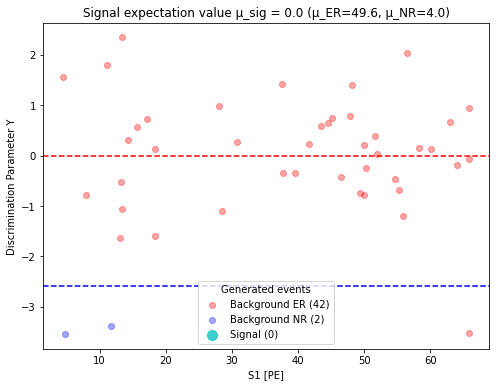

<ipython-input-7-b83707bdfb6a>:17: RuntimeWarning: invalid value encountered in log
  LL += np.log(mu_sig * pdf_signal(x[i]) * nr_discr.pdf(y[i]) + mu_bkgER * pdf_backgroundER(x[i]) * er_discr.pdf(y[i]) + mu_bkgNR * pdf_backgroundNR(x[i]) * nr_discr.pdf(y[i]))


Likelihood fit: 0.8 s
Fit convergence: True
Maximum Likelihood Estimator (MLE) µ_sig-hat: -1.0726857090150088
      fun: array([267.32717796])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.68434192e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 9
     njev: 21
   status: 0
  success: True
        x: array([-1.07268571])
Profile likelihood fit: 1.1 s
Fit convergence: True
Maximum Likelihood Estimator (MLE) µ_sig-hat: -1.986357104103191
      fun: 266.29014807556405
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373677e-05,  1.13686837e-05, -3.97903930e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([-1.9863571 , -0.58856163,  0.58016371])


<ipython-input-30-aede9c77978b>:24: RuntimeWarning: invalid value encountered in log
  LL += np.log(mu_sig * pdf_signal(x[i]) * nr_discr.pdf(y[i]) + mu_bkgER_ * pdf_backgroundER(x[i]) * er_discr.pdf(y[i]) + mu_bkgNR_ * pdf_backgroundNR(x[i]) * nr_discr.pdf(y[i]))


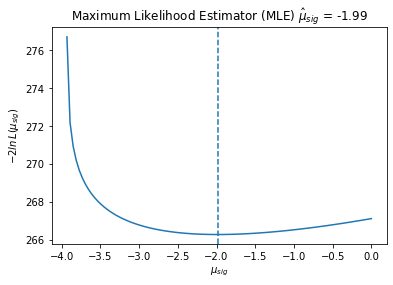

In [30]:
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Profile Likelihood function definition
#/////////////////////////////////////////////////////////////////////////////////////////////////
def logProfileLikelihood(parameters):
    '''
    -2 * Log-Likelihood function
    LL(mu_sig; t_bkgER, t_bkgNR)
    '''
    #print(t_bkgNR_star)
    # nuisance parameters
    t_bkgER = parameters[1]
    t_bkgNR = parameters[2]
    # expectation values
    mu_sig  = parameters[0]
    mu_bkgER_ = mu_bkgER * (1 + t_bkgER * sigma_bkgER) # mu_bkgER(t_bkgER)
    mu_bkgNR_ = mu_bkgNR * (1 + t_bkgNR * sigma_bkgNR) # mu_bkgNR(t_bkgNR)
    mu_tot = mu_sig + mu_bkgER_ + mu_bkgNR_
    # data points
    x = np.array(dataset.S1)
    y = np.array(dataset.Y)
    # log-Likelihood
    LL = - mu_tot
    for i in range(0, len(dataset)):
        LL += np.log(mu_sig * pdf_signal(x[i]) * nr_discr.pdf(y[i]) + mu_bkgER_ * pdf_backgroundER(x[i]) * er_discr.pdf(y[i]) + mu_bkgNR_ * pdf_backgroundNR(x[i]) * nr_discr.pdf(y[i]))
    LL -= 0.5 * (t_bkgER - t_bkgER_star)**2 # gaussian penalty term for nuisance parameter
    LL -= 0.5 * (t_bkgNR - t_bkgNR_star)**2 # gaussian penalty term for nuisance parameter
    #print(t_bkgNR, (0.5 * (t_bkgNR - t_bkgNR_star)**2))
    return -2*LL



#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Dataset generation with nuisance parameter sampling
#/////////////////////////////////////////////////////////////////////////////////////////////////
def generate_toy_dataset_nuis_params(mu_sig, mu_bkgER=mu_bkgER, mu_bkgNR=mu_bkgNR, plot=False):
    '''
    Returns
    dataset : a dataframe of generated events (Toy experiment)
    subsets : list of dataframes for signal, background ER and NR
    '''
    global t_bkgER_star
    global t_bkgNR_star
    t_bkgER_star = np.random.normal()
    t_bkgNR_star = np.random.normal()
    print('Extracted nuis params:', t_bkgER_star, t_bkgNR_star)
    mu_bkgER_ = mu_bkgER * (1 + t_bkgER_star * sigma_bkgER) # mu_bkgER(t_bkgER)
    mu_bkgNR_ = mu_bkgNR * (1 + t_bkgNR_star * sigma_bkgER) # mu_bkgNR(t_bkgNR)
    print('Expectation values:', mu_sig, mu_bkgER_, mu_bkgNR_)
    n_sig   = np.random.poisson(mu_sig) 
    n_bkgER = np.random.poisson(mu_bkgER_)
    n_bkgNR = np.random.poisson(mu_bkgNR_)
    #print('No. generated events:', n_sig, '(signal)', n_bkgER, '(bkgER)', n_bkgNR, '(bkgNR)')

    #/// Dataset generation
    dataset_sig   = generate_subset(pdf_signal,nr_discr,n_sig)
    dataset_bkgER = generate_subset(pdf_backgroundER,er_discr,n_bkgER)
    dataset_bkgNR = generate_subset(pdf_backgroundNR,nr_discr,n_bkgNR)
    subsets = [dataset_sig, dataset_bkgER, dataset_bkgNR]
    dataset = pd.DataFrame()
    dataset = dataset.append(subsets) # toy experiment
    
    if plot:
        plot_toy_dataset(subsets, mu_sig)
    
    return dataset, subsets

#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Likelihood fit on an example toy-experiment dataset
#/////////////////////////////////////////////////////////////////////////////////////////////////
#/// Toy-experiment dataset
dataset, subsets = generate_toy_dataset_nuis_params(mu_sig = 0, plot=True)

start = time()
fit_res = minimize(logLikelihood, mu_sig, bounds=[(-100,1000)])
end = time()
print('Likelihood fit: %.1f s' % (end-start))
mle = fit_res['x'][0]
print('Fit convergence:', fit_res['success'])
print(r'Maximum Likelihood Estimator (MLE) µ_sig-hat:', mle)
print(fit_res)


#/// Unconstrained likelihood minimization
# Maximum likelihood estimator of mu_sig
mu_sig = 10
start = time()
fit_res = minimize(logProfileLikelihood, (mu_sig,1,1), bounds=[(-100,1000),(-5,5),(-3,3)])
mle = fit_res['x'][0]
end = time()
print('Profile likelihood fit: %.1f s' % (end-start))
print('Fit convergence:', fit_res['success'])
print(r'Maximum Likelihood Estimator (MLE) µ_sig-hat:', mle)
print(fit_res)





#/// Plot log-Likelihood function vs mu_sig
mu = np.linspace(0,mle*2,100)
plt.plot(mu, logProfileLikelihood([mu,fit_res['x'][1],fit_res['x'][2]]))
plt.axvline(mle, ls='--')
plt.xlabel('$\mu_{sig}$')
plt.ylabel('$-2ln\,L(\mu_{sig})$')
plt.title('Maximum Likelihood Estimator (MLE) $\hat{\mu}_{sig}$ = %.2f' % mle)
plt.show()

# 4. SENSITIVITY WITH THE LIKELIHOOD RATIO METHOD

## 4.1 Expected test statistic PDF under null hypothesis: $f(q_\mu|H_0)$
- Generate $10^4$ toy-MCs under the background-only hypothesis $H_0$ 
- Compute $q_\mu$ on each toy-MC for a set of signal strengths $\mu_{sig}$ and build $f(q_\mu|H_0)$

## 4.2 Median sensitivity
- Based on the median values of $f(q_\mu|H_0)$ for each $\mu$, find the limit at 90% CL

## 4.3 1 and 2 sigma bands
- Find the 90% CL limit corresponding to the $\pm1$ and $\pm2\sigma$ quantiles of $f(q_\mu|H_0)$ to find the 1 and 2$\sigma$ bands of the sensitivity

## 4.4 Exclusion limit outcome vs expected sensitivity
- Compare the exclusion limit obtained previously with the given dataset with the expected sensitivity (median and 1/2 sigma bands)

### 4.4.1 CL$_s$ or Power constraint (?)
- Avoid too strong exclusion limits due to underfluctuations of background in the observed dataset

In [38]:
#dataset.to_pickle('example_dataset.pkl')

In [25]:
# Retrieve test statistic distributions
df_q = pd.read_pickle('test_stat_distributions.pkl')
df_q

,q_Hmu_10.0,q_H0_10.0,q_Hmu_20.0,q_H0_20.0,q_H0_1.0,q_Hmu_1.0
0,"[0.0, 1.4224864602456364, 0.0, 0.0, 0.0, 0.024...","[7.40653342506846, 25.11834907577014, 5.869243...","[0.19431464891999894, 4.667047065676115, 0.248...","[2.2430202818537737, 16.393276462520703, 15.09...","[0, 0.09673331038948163, 1.028856934470582, 0....","[0, 0.8577226487034864, 0, 4.122269827614332, ..."
